# FSDS Group Assessment (Group Safari)

### <span style="color:red">**READ ME !!!**
<span style="color:red">If you have run section 1 before, please run 1.1 and then jump to section 2.  
<span style="color:red">Please save data files under directory: ***'data/'*** which is in the same level as this ipynb file.

# 1. Data Collection and Cleaning

We will use 2 different datasets:
1. Airbnb data of London (10 Dec, 2022) downloading from [InsideAirbnb](http://insideairbnb.com/get-the-data)  
2. 2011 and 2021 Census data including:
* popchurn 11.csv
* MIG009EW_LTLA_OUT.csv
* MIG009EW_LTLA_IN.csv
* ethnic group 2011.csv
* ethnic group 2021.csv
* house price_median.xls
* house price_aver.xlsx
* Deprivation 2011.xls
* Deprivation 2021.csv


Note that all data in the Data subdirectory is ignored in the `.gitignore` file.

The file names that are used in this script are as follows.

|Data Type|File Name|df/gdf name|Gentrification Score df Name|Note|
|:---|:---|:---|:--|:--|
||`popchurn 11.csv`|`popch2011`|`2011migration`||
||`MIG009EW_LTLA_OUT.csv`|`moving2021`|`2021migration`||
||`MIG009EW_LTLA_IN.csv`||||
||`ethnic group 2011.csv`|`eg2011`|`nw_ratio11`||
||`ethnic group 2021.csv`|`eg2021`|`nw_ratio21`||
||`house price_median.xls`|`price_med`|`houseprice_change`||
||`house price_aver.xlsx`|`housing_df`|||
||`Deprivation 2011.xls`|`dpr2011`|`dpr2011%`||
||`Deprivation 2021.csv`|`dpr2021`|`dpr2021%`||
|`multipolygon`|`Boroughs.gpkg`|`boros`||`crs:27700`|
|`Airbnb listing`|`listings.csv.gz`|`ls`|`\`||
|`Airbnb listing -> geopandas`|`\`|`gls`|`\`|`crs:27700`|
||`gentrification_score.csv`|`\`|`\`|`Please save to local`|
||`borls.gpkg`|`\`|`\`|`Please save to local`|

## 1.1 Get Prepared

In [1]:
# Import packages
import os
from urllib.request import urlopen
from requests import get
from urllib.parse import urlparse
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import re

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [2]:
# Download data from remote location
def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    url = urlparse(src)
    fn  = os.path.split(url.path)[-1]
    dfn = os.path.join(dest,fn)
    
    if not os.path.isfile(dfn):
        print(f"{dfn} not found, downloading!")
        path = os.path.split(dest)
        
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)  
        print("\tDone downloading...")
    else:
        print(f"Found {dfn} locally!")
        
    return dfn

In [3]:
padir = 'data/'

## 1.2 Gentrification Score

### 1.2.1 Load the Data of Each Gentrification Index
<span style="color:red">**For now, I am using local files(which are under folder "data"), but I'll adjust it later to download directly using url.** </span>  

#### (a) Population Churn (migration)

In [4]:
# 2011 data
popch2011 = pd.read_csv(padir+'popchurn 11.csv', skiprows=7, skip_blank_lines=True, usecols=[
    'local authority: district / unitary (prior to April 2015)',
    'mnemonic',
    'Whole household lived at same address one year ago', 
    'Wholly moving household: Total']).dropna(how='all').iloc[:33]

# 2021 data
popch2021_in_raw = pd.read_csv(padir + 'MIG009EW_LTLA_IN.csv', usecols=['Lower tier local authorities code', 'Household migration LTLA (inflow) (7 categories) code', 'Count'])
popch2021_out_raw = pd.read_csv(padir + 'MIG009EW_LTLA_OUT.csv', usecols=['Migrant LTLA one year ago code', 'Household migration LTLA (outflow) (3 categories) code', 'Count'])

popch2021_in = popch2021_in_raw.loc[popch2021_in_raw['Lower tier local authorities code'].astype(str).str.match(r'^E090000[0-9]{2}$|^E09000[1-3][0-3]$', na=False)]
popch2021_out = popch2021_out_raw.loc[popch2021_out_raw['Migrant LTLA one year ago code'].astype(str).str.match(r'^E090000[0-9]{2}$|^E09000[1-3][0-3]$', na=False)]

## establish the dataframe and select the data 2021 based on the definition
popch2021 = pd.DataFrame()
popch2021['samead_2021'] = popch2021_in.loc[popch2021_in['Household migration LTLA (inflow) (7 categories) code'] == 1].groupby('Lower tier local authorities code')['Count'].sum()
popch2021['movein_2021']= popch2021_in.loc[(popch2021_in['Household migration LTLA (inflow) (7 categories) code'] >= 2) & (popch2021_in['Household migration LTLA (inflow) (7 categories) code'] <= 5)].groupby('Lower tier local authorities code')['Count'].sum()
popch2021['moveout_2021'] = popch2021_out.loc[(popch2021_out['Household migration LTLA (outflow) (3 categories) code'] >= 1) & (popch2021_out['Household migration LTLA (outflow) (3 categories) code'] <= 2)].groupby('Migrant LTLA one year ago code')['Count'].sum()

#### (b) Ethnic Group

In [5]:
#data,2011 and 2021
eg2011 = pd.read_csv(padir+'ethnic group 2011.csv', skiprows=7, header=0, skip_blank_lines=True, usecols=[
    'mnemonic','All categories: Ethnic group','White'])
eg2021 = pd.read_csv(padir+'ethnic group 2021.csv', skiprows=6, header=0, skip_blank_lines=True, usecols=[
    'mnemonic','Total: All usual residents','White'])
# select data by borough code, 2011 and 2021
eg2011 = eg2011[eg2011['mnemonic'].astype(str).str.startswith('E09')]
eg2021 = eg2021[eg2021['mnemonic'].astype(str).str.startswith('E09')]
# set the borough code as index
eg2011.set_index('mnemonic', inplace=True)
eg2021.set_index('mnemonic', inplace=True)

#### (c) Housing Price

In [6]:
# median housing price,2011 and 2021
price_med_raw = pd.read_excel(padir+'house price_median.xls',sheet_name='1a',engine='xlrd',skiprows=5,header=0,usecols=[
    'Local authority code','Year ending Dec 2001','Year ending Dec 2021'])
price_med = price_med_raw.loc[price_med_raw['Local authority code'].astype(str).str.contains(r'^E09', regex=True)]
price_med.set_index('Local authority code', inplace=True)

# select data in 2011 and 2021
Housing_med_df = pd.DataFrame()
Housing_med_df ['median_2011'] =price_med.loc[:, ['Year ending Dec 2001']]
Housing_med_df['median_2021'] =price_med.loc[:, ['Year ending Dec 2021']]
Housing_med_df = Housing_med_df.groupby('Local authority code')[['median_2011', 'median_2021']].median()

In [7]:
# average housing price,2011 and 2021 
housing_price = "house price_aver.xlsx"
housing_df = pd.read_excel(os.path.join(padir,housing_price),sheet_name=2,skiprows=1, header=0,index_col=0)

# set the index to datetime data
housing_df.index = pd.to_datetime(housing_df.index, format='%Y%m%d')
# set the column and index name
housing_df.columns.name = 'London_borough'
housing_df.index.name = 'year'
# check the index(year) type
print(housing_df.index.dtype)
# select the london borough data
London_housing_df = housing_df.filter(regex='^E09', axis=1)
# change the column and index location 
London_housing_df = London_housing_df.transpose()
# check the data
London_housing_df.head(3) 

# select the data of 2011 and 2021
housing_ave_df = pd.DataFrame()
housing_ave_df ['average_2011'] =London_housing_df.loc[:, ['2011-12-01']]
housing_ave_df ['average_2021'] =London_housing_df.loc[:, ['2012-12-01']]
housing_ave_df.head(10) 

datetime64[ns]


,average_2011,average_2021
London_borough,,
E09000001,496290.8438,491528.7635
E09000002,162631.3061,167813.0248
E09000003,346652.9974,361370.6666
E09000004,199523.2257,206956.1398
E09000005,301759.5506,322170.5341
E09000006,278849.1468,288681.6021
E09000007,547656.5284,620350.6021
E09000008,217808.9162,226742.0544
E09000009,303094.5273,327287.6027


#### (d) Deprivation

In [8]:
# data 2011
dpr2011_raw = pd.read_excel(padir+'deprivation 2011.xls',sheet_name='QS119EW_Percentages',engine='xlrd',skiprows=10,header=0, usecols=[
    'Area code','Household is not deprived in any dimension'])
dpr2011 = dpr2011_raw.loc[dpr2011_raw['Area code'].astype(str).str.contains(r'^E090000[0-2][0-9]$|^E090003[0-3]$|^E090000[1-9][0-9]$|^E09000[1-3][0-3]$'
, regex=True)]

# data 2021
dpr2021_raw = pd.read_csv(padir+'deprivation 2021.csv')
dpr2021 = dpr2021_raw[dpr2021_raw['Upper tier local authorities Code'].astype(str).str.contains(
    r'^E090000[0-2][0-9]$|^E090003[0-3]$|^E090000[1-9][0-9]$|^E09000[1-3][0-3]$', regex=True)]

### 1.2.2 Calculate Each Gentrification index
G = 1/2c - 1/4e + 1/8h - 1/8d + 0.25  
    G: gentrification score  
    c: population churn at household level - the ratio of the households that have changed  
    e: ethnic group - the change of the proportion of non-white residents  
    h: housing price - relative change in median house price compared with acerage price  
    d: deprivation - relative change in the proportion of households with deprivation dimensions

#### (0)G: establish dataframe for gentrification score

In [9]:
gtr = pd.DataFrame()

#### (a) c: Population Churn (Household Level)  
* give a equation

In [10]:
## 2011 migrantion (household level)
popch2011['2011migration'] = (
    (popch2011['Wholly moving household: Total'] /
    (popch2011['Wholly moving household: Total'] + popch2011['Whole household lived at same address one year ago'])))

gtr['borough'] = popch2011['local authority: district / unitary (prior to April 2015)']
gtr['borough code'] = popch2011['mnemonic'].astype(str)
gtr['2011migration'] = popch2011['2011migration']
gtr.set_index('borough code', inplace=True)

In [11]:
## 2021 migrantion (household level)
popch2021['2021migration'] = (popch2021['movein_2021'] + 
                              popch2021['moveout_2021'])/ (popch2021['samead_2021'] + 
 popch2021['movein_2021'] + popch2021['moveout_2021'])
# Merge the result of population churn into gtr based on 'borough code' and 'code'
gtr ['2021migration']= popch2021['2021migration']
# add 'popchurn' column: 
gtr['popchurn'] = gtr['2021migration'] - gtr['2011migration']

#### (b) e: Non-white Ethnic Group Proportion Change
* give a equation

In [12]:
# Calculate the no-white ratio for 2011
eg2011['nw_ratio11'] = (1 - eg2011['White'] / eg2011['All categories: Ethnic group'])
# Calculate the no-white ratio for 2021
eg2021['nw_ratio21'] = (1 - eg2021['White'] / eg2021['Total: All usual residents'])

In [13]:
# links the no-white ratio to gtr dataframe
gtr ['nw_ratio11'] = eg2011['nw_ratio11']
gtr ['nw_ratio21']= eg2021['nw_ratio21'] 
# add 'ethnic group change' column
gtr['ethgr'] = (gtr['nw_ratio21'] - gtr['nw_ratio11'])/ eg2011['nw_ratio11']

#### (c) h: Housing Price Change(Median/Average) 
* give a equation

In [14]:
# link the median data and average data
total_housing_df = pd.merge(housing_ave_df,Housing_med_df, left_index=True, right_index=True)
# calculate the change of housing price
total_housing_df['Housing_Compare_2011'] = total_housing_df['median_2011']/total_housing_df['average_2011']
total_housing_df['Housing_Compare_2021'] = total_housing_df['median_2021']/total_housing_df['average_2021']
total_housing_df['houseprice_change'] = (total_housing_df['Housing_Compare_2021']-total_housing_df['Housing_Compare_2011']) / total_housing_df['Housing_Compare_2011']

# link the housing data set to grf
gtr = pd.merge(gtr, total_housing_df[['Housing_Compare_2011','Housing_Compare_2021','houseprice_change']], left_index=True, right_index=True)

#### (d) d: Deprivation Proportion Change
* give a equation

In [15]:
# select the 2021 data by the definition of index
dpr2021_nodpr = dpr2021[dpr2021['Household deprivation (6 categories) Code'] == 1]
dpr2021_all = dpr2021[(dpr2021['Household deprivation (6 categories) Code'] >= 1) & (dpr2021['Household deprivation (6 categories) Code'] <= 5)]
sum = dpr2021_all.groupby('Upper tier local authorities Code')['Observation'].sum()

ratios = 1- (dpr2021_nodpr.groupby('Upper tier local authorities Code')['Observation'].sum() / sum)*100 

# Create a new DataFrame by merging 'dpr2011' and 'ratios'
Dep_result_df = pd.merge(dpr2011, ratios, left_on='Area code', right_index=True, how='left')
Dep_result_df = Dep_result_df.rename(columns={'Observation': 'dpr2021%',
                                      'Household is not deprived in any dimension': 'dpr2011%'})
Dep_result_df.set_index('Area code', inplace=True)

In [16]:
# links the deprivation index to gtr dataset
gtr['dpr2011%']= Dep_result_df['dpr2011%']
gtr['dpr2021%']= Dep_result_df['dpr2021%']
gtr['dpr'] = (gtr['dpr2021%'] - gtr['dpr2011%'])/gtr['dpr2011%']

In [17]:
# check the final result of gtr dataframe
gtr

,borough,2011migration,2021migration,popchurn,nw_ratio11,nw_ratio21,ethgr,Housing_Compare_2011,Housing_Compare_2021,houseprice_change,dpr2011%,dpr2021%,dpr
E09000002,Barking and Dagenham,0.113141,0.110965,-0.002176,0.417980,0.550991,0.318225,0.540310,1.988821,2.680891,28.2,-36.591675,-2.297577
E09000003,Barnet,0.135282,0.134497,-0.000785,0.359116,0.422716,0.177101,0.533675,1.660345,2.111155,43.2,-48.573264,-2.124381
E09000004,Bexley,0.085597,0.092283,0.006686,0.183877,0.281209,0.529329,0.601352,1.903785,2.165840,41.5,-47.518872,-2.145033
E09000005,Brent,0.140259,0.151894,0.011635,0.638321,0.653638,0.023996,0.525770,1.580685,2.006416,30.9,-38.941996,-2.260259
E09000006,Bromley,0.109365,0.106850,-0.002514,0.158705,0.235449,0.483565,0.568408,1.697372,1.986187,48.5,-53.642302,-2.106027
E09000007,Camden,0.193798,0.210687,0.016888,0.337890,0.404843,0.198149,0.455988,1.302691,1.856851,37.9,-46.523151,-2.227524
E09000001,City of London,0.270857,0.322132,0.051275,0.214102,0.306267,0.430477,0.478550,1.622489,2.390427,45,-58.768010,-2.305956
E09000008,Croydon,0.115195,0.119348,0.004153,0.449716,0.516321,0.148104,0.573898,1.758606,2.064321,41,-46.994717,-2.146213
E09000009,Ealing,0.137726,0.140970,0.003244,0.510951,0.568357,0.112351,0.544385,1.588817,1.918555,37.4,-45.034656,-2.204135
E09000010,Enfield,0.120092,0.109127,-0.010965,0.390987,0.479116,0.225402,0.532801,1.726798,2.240980,36.1,-41.187397,-2.140925


### 1.2.3 Calculate Gentrification Score
G = 1/2c - 1/4e + 1/8h - 1/8d + 0.25  
    G: gentrification score  

In [18]:
gtr['score'] = (1/2*gtr['popchurn'] - 1/4*gtr['ethgr'] 
                + 1/8*gtr['houseprice_change'] -1/8*gtr['dpr']) + 0.25

## 1.3 Airbnb data

#### a) Borough with gentrification socre

In [40]:
# boroughs
boros = gpd.read_file(cache_data('https://github.com/jreades/fsds/blob/master/data/src/Boroughs.gpkg?raw=true', padir+'Boroughs.gpkg') )
boros.set_index('GSS_CODE',inplace = True)

# add gentrification score to borough dataframe
boros ['score'] =  gtr[ 'score']

boros.to_crs(epsg=4326, inplace=True)
print(boros.crs)
boros.head(5)

data/Boroughs.gpkg/Boroughs.gpkg not found, downloading!
	Done downloading...
EPSG:4326


,NAME,HECTARES,NONLD_AREA,ONS_INNER,geometry,score
GSS_CODE,,,,,,
E09000021,Kingston upon Thames,3726.117,0.000,F,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...",0.696082
E09000008,Croydon,8649.441,0.000,F,"MULTIPOLYGON (((-0.06402 51.31864, -0.06408 51...",0.741367
E09000006,Bromley,15013.487,0.000,F,"MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...",0.639378
E09000018,Hounslow,5658.541,60.755,F,"MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51...",0.719436
E09000009,Ealing,5554.428,0.000,F,"MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51...",0.738871


#### b) Lisitings

In [41]:
# listings
url = 'http://data.insideairbnb.com/united-kingdom/england/london/2022-12-10/data/listings.csv.gz'
ls = pd.read_csv(cache_data(url, padir),compression='gzip',usecols=['id','latitude','longitude','price','minimum_nights'])
ls['price'] = ls['price'].str.replace('$','', regex=False).str.replace(',','', regex=False).astype(float)
# drop the na value
ls = ls.dropna()

data/listings.csv.gz not found, downloading!
	Done downloading...


In [42]:
# change listings to geodataframe
gls = gpd.GeoDataFrame(ls, 
      geometry=gpd.points_from_xy(ls.longitude, ls.latitude))
gls.set_crs(epsg=4326, inplace=True)
print(gls.head(5))
print(gls.crs)

       id   latitude  longitude  price  minimum_nights  \
0   13913  51.568610  -0.112700   79.0               1   
1   15400  51.487800  -0.168130   75.0              10   
2  172811  51.547100  -0.179810  229.0              21   
3  173082  51.538254  -0.044086  132.0               2   
4   42010  51.585900  -0.164340   65.0               4   

                    geometry  
0  POINT (-0.11270 51.56861)  
1  POINT (-0.16813 51.48780)  
2  POINT (-0.17981 51.54710)  
3  POINT (-0.04409 51.53825)  
4  POINT (-0.16434 51.58590)  
EPSG:4326


<Axes: >

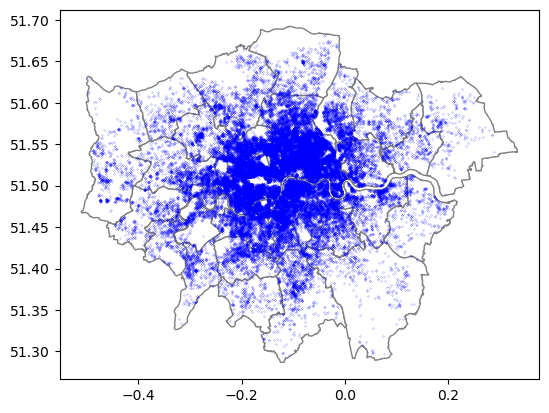

In [22]:
fig, ax = plt.subplots()
# plot the map
boros.plot(ax=ax, edgecolor='grey', facecolor='white',markersize=3)
gls.plot(ax=ax, color='blue', markersize=0.02)

#### c) Spacial Join

In [43]:
# spatial join based on the borough boundaries and point locations
borls = gpd.sjoin(gls,boros, how='left', op='within')

/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [44]:
borls.head(20)

,id,latitude,longitude,price,minimum_nights,geometry,index_right,NAME,HECTARES,NONLD_AREA,ONS_INNER,score
0,13913,51.568610,-0.112700,79.0,1,POINT (-0.11270 51.56861),E09000019,Islington,1485.664,0.000,T,0.743521
1,15400,51.487800,-0.168130,75.0,10,POINT (-0.16813 51.48780),E09000020,Kensington and Chelsea,1238.379,25.994,T,0.681993
2,172811,51.547100,-0.179810,229.0,21,POINT (-0.17981 51.54710),E09000007,Camden,2178.932,0.000,T,0.719454
3,173082,51.538254,-0.044086,132.0,2,POINT (-0.04409 51.53825),E09000012,Hackney,1904.902,0.000,T,0.831243
4,42010,51.585900,-0.164340,65.0,4,POINT (-0.16434 51.58590),E09000003,Barnet,8674.837,0.000,F,0.734774
5,17402,51.521950,-0.140940,425.0,4,POINT (-0.14094 51.52195),E09000033,Westminster,2203.005,54.308,T,0.741294
6,42692,51.508220,-0.215620,125.0,1,POINT (-0.21562 51.50822),E09000013,Hammersmith and Fulham,1715.409,75.648,T,0.707007
7,43129,51.481640,-0.210820,60.0,3,POINT (-0.21082 51.48164),E09000013,Hammersmith and Fulham,1715.409,75.648,T,0.707007
8,43202,51.530310,-0.217130,141.0,4,POINT (-0.21713 51.53031),E09000005,Brent,4323.270,0.000,F,0.783153
9,43742,51.551430,-0.094930,78.0,1,POINT (-0.09493 51.55143),E09000019,Islington,1485.664,0.000,T,0.743521


#### d) Short-term Rent 

In [45]:
borls['s_rent'] = borls['minimum_nights'].apply(lambda x: 1 if x <= 28 else 0)

In [46]:
borls_new = borls.groupby(['index_right', 'score','HECTARES']).agg({
    'price': 'mean',
    's_rent': 'sum',
    'index_right': 'count'
}).rename(columns={'index_right': 'num_listings',
                  'price': 'average_price'}).reset_index()

# airbnb listings density
borls_new ['density'] = borls_new ['num_listings']/ borls_new ['HECTARES']
borls_new ['shortterm%'] = borls_new ['s_rent']/borls_new ['num_listings']

borls_new.set_index('index_right',inplace=True)
borls_new

,score,HECTARES,average_price,s_rent,num_listings,density,shortterm%
index_right,,,,,,,
E09000001,0.755066,314.942,218.839501,402,421,1.336754,0.954869
E09000002,0.791664,3779.934,106.420000,436,450,0.119050,0.968889
E09000003,0.734774,8674.837,147.647217,1645,1689,0.194701,0.973949
E09000004,0.659870,6428.649,90.762579,341,349,0.054288,0.977077
E09000005,0.783153,4323.270,208.811066,2165,2223,0.514194,0.973909
E09000006,0.639378,15013.487,118.563126,602,611,0.040697,0.985270
E09000007,0.719454,2178.932,190.967916,4665,4822,2.213011,0.967441
E09000008,0.741367,8649.441,97.647793,1103,1128,0.130413,0.977837
E09000009,0.738871,5554.428,123.901982,1695,1746,0.314344,0.970790


In [47]:
l = ['average_price','num_listings','density','shortterm%']
for i in l:
    boros[i]= borls_new [i]
boros

,NAME,HECTARES,NONLD_AREA,ONS_INNER,geometry,score,average_price,num_listings,density,shortterm%
GSS_CODE,,,,,,,,,,
E09000021,Kingston upon Thames,3726.117,0.000,F,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...",0.696082,209.639515,577,0.154853,0.980936
E09000008,Croydon,8649.441,0.000,F,"MULTIPOLYGON (((-0.06402 51.31864, -0.06408 51...",0.741367,97.647793,1128,0.130413,0.977837
E09000006,Bromley,15013.487,0.000,F,"MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...",0.639378,118.563126,611,0.040697,0.985270
E09000018,Hounslow,5658.541,60.755,F,"MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51...",0.719436,157.616162,1089,0.192452,0.976125
E09000009,Ealing,5554.428,0.000,F,"MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51...",0.738871,123.901982,1746,0.314344,0.970790
E09000016,Havering,11445.735,210.763,F,"MULTIPOLYGON (((0.15869 51.51219, 0.15871 51.5...",0.566655,111.456311,309,0.026997,0.980583
E09000017,Hillingdon,11570.063,0.000,F,"MULTIPOLYGON (((-0.40407 51.61318, -0.40388 51...",0.684208,99.275813,664,0.057389,0.972892
E09000015,Harrow,5046.330,0.000,F,"MULTIPOLYGON (((-0.40407 51.61318, -0.40320 51...",0.743937,100.805226,421,0.083427,0.954869
E09000005,Brent,4323.270,0.000,F,"MULTIPOLYGON (((-0.19657 51.52765, -0.19685 51...",0.783153,208.811066,2223,0.514194,0.973909


<Axes: >

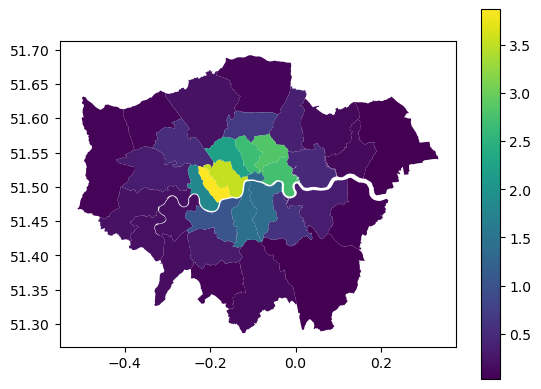

In [48]:
fig, ax = plt.subplots()
boros.plot(ax=ax, column='density', legend=True, markersize=10)

#### e) Save borough & listings to local

In [49]:
# borough.gpkg: multipolygon of boroughs with 1) columns gentrification score & 2)statistics of airbnb data
boros_path = padir+'boro_new.gpkg'
if not os.path.exists(boros_path):
    print('Saving boroughs_new...')
    boros.to_file(boros_path, layer='merged_layer', driver='GPKG')

# boro_ls.gpkg: point of 1) Airbnb listings & 2) gentrification score
borolist_path = padir+'borough_list.gpkg'
if not os.path.exists(borolist_path):
    print('Saving boroughlist...')
    borls.to_file(borolist_path, layer='merged_layer', driver='GPKG')

Saving boroughs_new...
Saving boroughlist...


### <span style="color:red">If you have run section 1 before, please run 1.1 and then jump to section 2.

# 2. Data Analysis

## 2.1 Load Data

 **<span style="color:red">If this is the first time running this code, please jump 2.1 directly to 2.2**

In [50]:
# borough.gpkg: multipolygon of boroughs with 1) columns gentrification score & 2)statistics of airbnb data
boros = gpd.read_file(padir+'boro_new.gpkg')
borolist = gpd.read_file(padir+'borough_list.gpkg')
boros.head(5)

,GSS_CODE,NAME,HECTARES,NONLD_AREA,ONS_INNER,score,average_price,num_listings,density,shortterm%,geometry
0,E09000021,Kingston upon Thames,3726.117,0.000,F,0.6960824905499479,209.639515,577,0.154853,0.980936,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51..."
1,E09000008,Croydon,8649.441,0.000,F,0.7413672474386982,97.647793,1128,0.130413,0.977837,"MULTIPOLYGON (((-0.06402 51.31864, -0.06408 51..."
2,E09000006,Bromley,15013.487,0.000,F,0.6393783863786204,118.563126,611,0.040697,0.985270,"MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2..."
3,E09000018,Hounslow,5658.541,60.755,F,0.7194364407728487,157.616162,1089,0.192452,0.976125,"MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51..."
4,E09000009,Ealing,5554.428,0.000,F,0.7388706115316723,123.901982,1746,0.314344,0.970790,"MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51..."


In [51]:
# boro_ls.gpkg: point of 1) Airbnb listings & 2) gentrification score
borolist.head(5)

,id,latitude,longitude,price,minimum_nights,index_right,NAME,HECTARES,NONLD_AREA,ONS_INNER,score,s_rent,geometry
0,13913,51.568610,-0.112700,79.0,1,E09000019,Islington,1485.664,0.000,T,0.7435213309015983,1,POINT (-0.11270 51.56861)
1,15400,51.487800,-0.168130,75.0,10,E09000020,Kensington and Chelsea,1238.379,25.994,T,0.6819934196380129,1,POINT (-0.16813 51.48780)
2,172811,51.547100,-0.179810,229.0,21,E09000007,Camden,2178.932,0.000,T,0.7194537086179889,1,POINT (-0.17981 51.54710)
3,173082,51.538254,-0.044086,132.0,2,E09000012,Hackney,1904.902,0.000,T,0.8312425274566146,1,POINT (-0.04409 51.53825)
4,42010,51.585900,-0.164340,65.0,4,E09000003,Barnet,8674.837,0.000,F,0.7347741279891916,1,POINT (-0.16434 51.58590)


## 0.1 data in My repo

In [ ]:
## local csv
dpr2011_raw = pd.read_excel(padir+'deprivation 2011.xls',sheet_name='QS119EW_Percentages',engine='xlrd',skiprows=10,header=0, usecols=[
    'Area code','Household is not deprived in any dimension'])
## jreads github
boros = gpd.read_file(cache_data('https://github.com/jreades/fsds/blob/master/data/src/Boroughs.gpkg?raw=true', padir+'Boroughs.gpkg') )
boros.set_index('GSS_CODE',inplace = True)

In [55]:
dpr2011_url = 'https://github.com/JunruHuang/Safari_data/blob/main/Deprivation%202011.xls?raw=true'
dpr2011 = pd.read_excel(cache_data(dpr2011_url, padir),sheet_name='QS119EW_Percentages',engine='xlrd',skiprows=10,header=0, usecols=[
    'Area code','Household is not deprived in any dimension'])

Found data/Deprivation%202011.xls locally!


XLRDError: Unsupported format, or corrupt file: Expected BOF record; found b'{"payloa'

In [ ]:
dpr2011